# Jores et al 2021 Intepretation
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to interpret the best trained models on the Jores et al (2021) dataset.
***

In [25]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

In [56]:
# General imports
import os
import glob
import torch
import numpy as np
import xarray as xr

# EUGENe imports and settings
from eugene import models
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/jores21"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/jores21"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/jores21"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/jores21"

# EUGENe packages
import seqdata as sd
import seqpro as sp
import seqexplainer as se

# For illustrator editing
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Load in the `leaf`, `proto` and `combined` test `SeqData`s 

In [6]:
sdata_leaf = sd.open_zarr(os.path.join(settings.output_dir, "leaf", "jores21_leaf_test_predictions.zarr"))

# Load the best model

In [221]:
leaf_model_file = glob.glob(os.path.join(settings.logging_dir, "cnn", "leaf_trial_3", "checkpoints", "*"))[0]
model = models.load_config(config_path="cnn.yaml")
leaf_model = models.SequenceModule.load_from_checkpoint(leaf_model_file, arch=model.arch)

/cellar/users/aklie/projects/ML4GLand/SeqExplainer/seqexplainer/_references.py:152: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if bg is "uniform":
/cellar/users/aklie/projects/ML4GLand/SeqExplainer/seqexplainer/_references.py:156: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif bg is "batch":
/cellar/users/aklie/projects/ML4GLand/SeqExplainer/seqexplainer/_references.py:160: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif bg is "seq":
[rank: 0] Global seed set to 3


In [7]:
leaf_model_file = glob.glob(os.path.join(settings.logging_dir, "jores21_cnn", "leaf_trial_3", "checkpoints", "*"))[0]
model = models.load_config(config_path="jores21_cnn.yaml")
leaf_model = models.SequenceModule.load_from_checkpoint(leaf_model_file, arch=model.arch)

[rank: 0] Global seed set to 3


In [222]:
# Choose which model you want to intepret
name = "leaf"
model = leaf_model
sdata = sdata_leaf
model, sdata

(SequenceModule(
   (arch): CNN(
     (conv1d_tower): Conv1DTower(
       (layers): Sequential(
         (0): Conv1d(4, 256, kernel_size=(13,), stride=(1,), padding=valid)
         (1): ReLU()
         (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (3): Dropout(p=0.3, inplace=False)
         (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (5): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=valid)
         (6): ReLU()
         (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (8): Dropout(p=0.3, inplace=False)
         (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (10): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=valid)
         (11): ReLU()
         (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (13): Dropout(p=0.3, inplace=False)
         (14): B

# Feature attribution

In [223]:
import seqexplainer as se

In [224]:
from tqdm.auto import tqdm
def attribute_sdata(
    model,
    sdata,
    seq_key="ohe_seq",
    method="InputXGradient",
    reference_type=None,
    target=0,
    batch_size=None,
    device=None,
    num_workers=None,
    prefetch_factor=None,
    transforms={},
    prefix="",
    suffix="",
    copy= False
):
    sdata = sdata.copy() if copy else sdata

    # Configure the device, batch size, and number of workers
    device = "cuda" if settings.gpus > 0 else "cpu" if device is None else device
    batch_size = batch_size if batch_size is not None else settings.batch_size
    num_workers = num_workers if num_workers is not None else settings.dl_num_workers
    prefetch_factor = prefetch_factor if prefetch_factor is not None else None

    # Create the dataloader
    dl = sd.get_torch_dataloader(
        sdata,
        sample_dims=["_sequence"],
        variables=[seq_key],
        batch_size=batch_size,
        num_workers=num_workers,
        prefetch_factor=prefetch_factor,
        transforms=transforms,
        shuffle=False,
        drop_last=False
    )
    attrs = []
    for _, batch in tqdm(enumerate(dl), total=len(dl), desc=f"Computing saliency on batches of size {batch_size}"):
        attr = se.attribute(
            model=model,
            inputs=batch[seq_key],
            method=method,
            reference_type=reference_type,
            target=target,
            batch_size=batch_size,
            device=device,
            verbose=False
        )
        attrs.append(attr)
    attrs = np.concatenate(attrs)
    sdata[f"{prefix}{method}_attrs{suffix}"] = xr.DataArray(attrs, dims=["_sequence", "_ohe", "length"])
    return sdata if copy else None

In [250]:
attribute_sdata(
    model,
    sdata,
    method="DeepLift",
    reference_type="gc",
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)}
)

Computing saliency on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


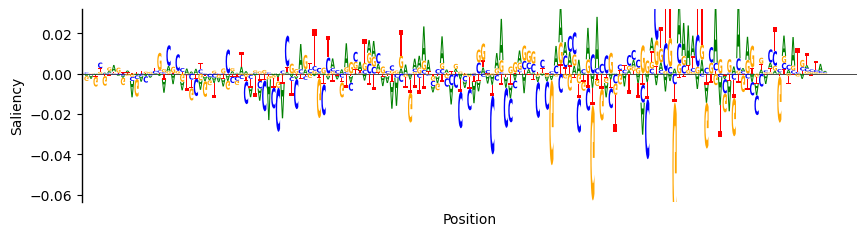

In [251]:
seq_id = "seq00000"
pl.seq_track(
    sdata,
    seq_id,
    attrs_key="DeepLift_attrs",
)

In [96]:
attr_keys = ["DeepLift_attrs"]

In [97]:
example_attr = sdata[attr_keys[0]][0]

In [102]:
# Get the length dimension 
example_attr.sizes["length"]

170

Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

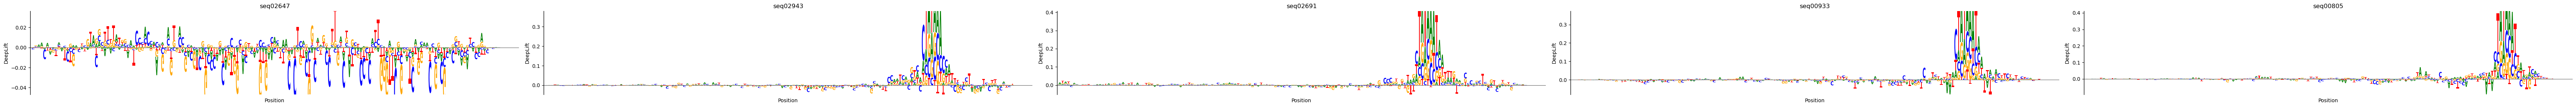

In [252]:
# Grab the top 5 in terms of predictions to plot tracks for
top5_inds = sdata["jores21_cnn_leaf_trial_5_preds"].to_series().sort_values(ascending=False).iloc[:5].index
top5_ids = sdata["id"][top5_inds].values
top5_vals = sdata["jores21_cnn_leaf_trial_5_preds"][top5_inds].values

pl.multiseq_track(
    sdata,
    seq_ids=top5_ids,
    attrs_keys = "DeepLift_attrs",
    ylabs="DeepLift",
    height=3,
    width=70,
    #save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_feature_attr.pdf")
)

# Filter viz

In [163]:
import importlib
import logging
import os
from typing import Callable, Dict
import pandas as pd
import torch
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, key_word: str, index: int = None):
        super().__init__()
        print("here")
        self.model = model
        layers = sorted([k for k in dict([*model.named_modules()]) if key_word in k])
        self.features = {layer: torch.empty(0) for layer in layers}
        self.handles = dict()
        self.index = index

        for layerID in layers:
            layer = dict([*self.model.named_modules()])[layerID]
            handle = layer.register_forward_hook(self.SaveOutputHook(layerID, self.index))
            self.handles[layerID] = handle
            
    def SaveOutputHook(self, layerID: str, index: int = None) -> Callable:
        def fn(layer, input, output):
            if self.index is not None:
                self.features[layerID] = output[self.index]
            else:
                self.features[layerID] = output
        return fn

    def forward(self, x, **kwargs) -> Dict[str, torch.Tensor]:
        preds = self.model(x, **kwargs)
        return self.features, self.handles, preds

In [134]:
from seqexplainer._utils import get_layer, get_layer_outputs
from seqexplainer._filters import get_activators_n_seqlets, get_activators_max_seqlets
from seqexplainer._filters import get_pfms, pfms_to_df_dict
from seqexplainer._filters import pfms_to_ppms, ppms_to_pwms, ppms_to_igms, per_position_ic
from seqexplainer._filters import plot_filter_logo, plot_filter_logos

In [228]:
model

SequenceModule(
  (arch): CNN(
    (conv1d_tower): Conv1DTower(
      (layers): Sequential(
        (0): Conv1d(4, 256, kernel_size=(13,), stride=(1,), padding=valid)
        (1): ReLU()
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.3, inplace=False)
        (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=valid)
        (6): ReLU()
        (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (8): Dropout(p=0.3, inplace=False)
        (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=valid)
        (11): ReLU()
        (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (13): Dropout(p=0.3, inplace=False)
        (14): BatchNorm1d(256, eps

In [235]:
layer_name = "arch.conv1d_tower.layers.1"

In [236]:
test = FeatureExtractor(model, layer_name)

here


In [231]:
sequences = sdata["ohe_seq"].transpose("_sequence", "_ohe", "length").values[:128]
torch_seqs = torch.tensor(sequences, dtype=torch.float32).to("cuda")
torch_seqs.shape

torch.Size([128, 4, 170])

In [237]:
test(torch_seqs)[0][layer_name][0].T

tensor([[15.3382, 11.3875,  8.4752,  ...,  1.0636,  0.0000,  0.0000],
        [ 8.1250,  9.5304,  2.2797,  ...,  0.6090,  0.6182,  0.0000],
        [13.0612,  7.2628,  7.6830,  ...,  0.0000,  0.0000,  0.1426],
        ...,
        [23.6478,  8.0108,  2.6057,  ...,  0.0000,  0.0000,  0.0000],
        [13.6831, 12.9718,  4.4256,  ...,  0.0000,  0.0000,  0.0000],
        [14.5379, 14.3516,  3.8993,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', grad_fn=<PermuteBackward0>)

In [168]:
import torch.nn.functional as F
def get_layer(
    model, 
    layer_name,
    index=None
):
    if index is not None:
        return dict([*model.named_modules()])[layer_name][index]
    else:
        return dict([*model.named_modules()])[layer_name]

In [189]:
layer = get_layer(model, layer_name, index=0)
layer_outs = F.relu(F.conv1d(torch_seqs, layer)).detach().cpu().numpy()

In [242]:
sequences = sdata["ohe_seq"].transpose("_sequence", "_ohe", "length").values

In [243]:
layer_outs = get_layer_outputs(model, sequences, layer_name, device="cuda")

Computing layer outputs for layer arch.conv1d_tower.layers.1 on batches of size 128:   0%|          | 0/56 [00…

In [244]:
activators = get_activators_n_seqlets(
    layer_outs,
    sequences,
    kernel_size=13,
    num_seqlets=100
)
pfms = get_pfms(activators)
pfm_dfs = pfms_to_df_dict(pfms)
ppms = pfms_to_ppms(pfms, pseudocount=1)
pwms = ppms_to_pwms(ppms)
infos = ppms_to_igms(ppms)
ppics = per_position_ic(ppms)
tot_ics = ppics.sum(axis=1)

Getting filter activators for 256 filters:   0%|          | 0/256 [00:00<?, ?it/s]

In [247]:
prefix = ""
suffix = ""
sdata[f"{prefix}{layer_name}_pfms{suffix}"] = xr.DataArray(pfms, dims=["_num_kernels", "kernel_size", "_ohe"])

In [191]:
# Sort by total information content
sort_idx = np.argsort(tot_ics)[::-1]
sort_idx[:5]

array([ 46,  50,  72,  80, 140])

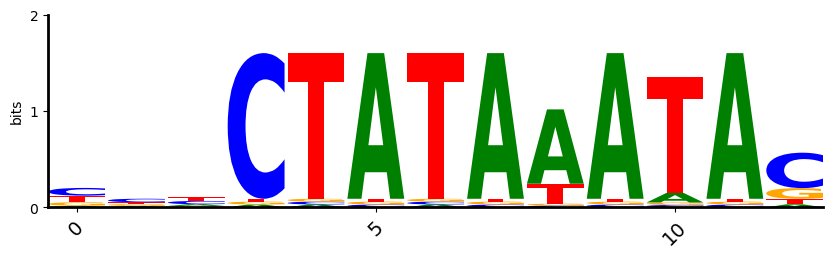

In [245]:
plot_filter_logo(mtx=pfms[0], mtx_type="counts")

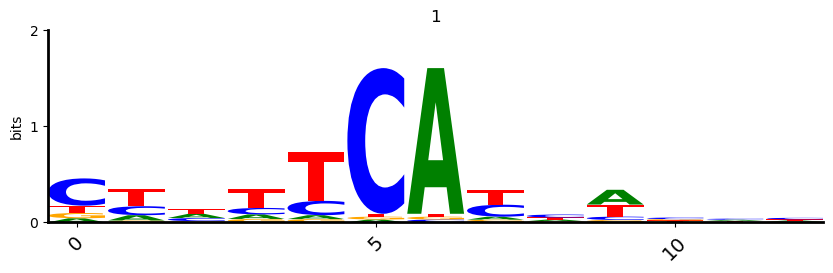

In [216]:
# Visualize a filter of choice
pl.filter_viz(
    sdata,
    filter_num=1,
    pfms_key=f"{prefix}{layer_name}_pfms{suffix}",
)

Plotting and saving filters 1-32


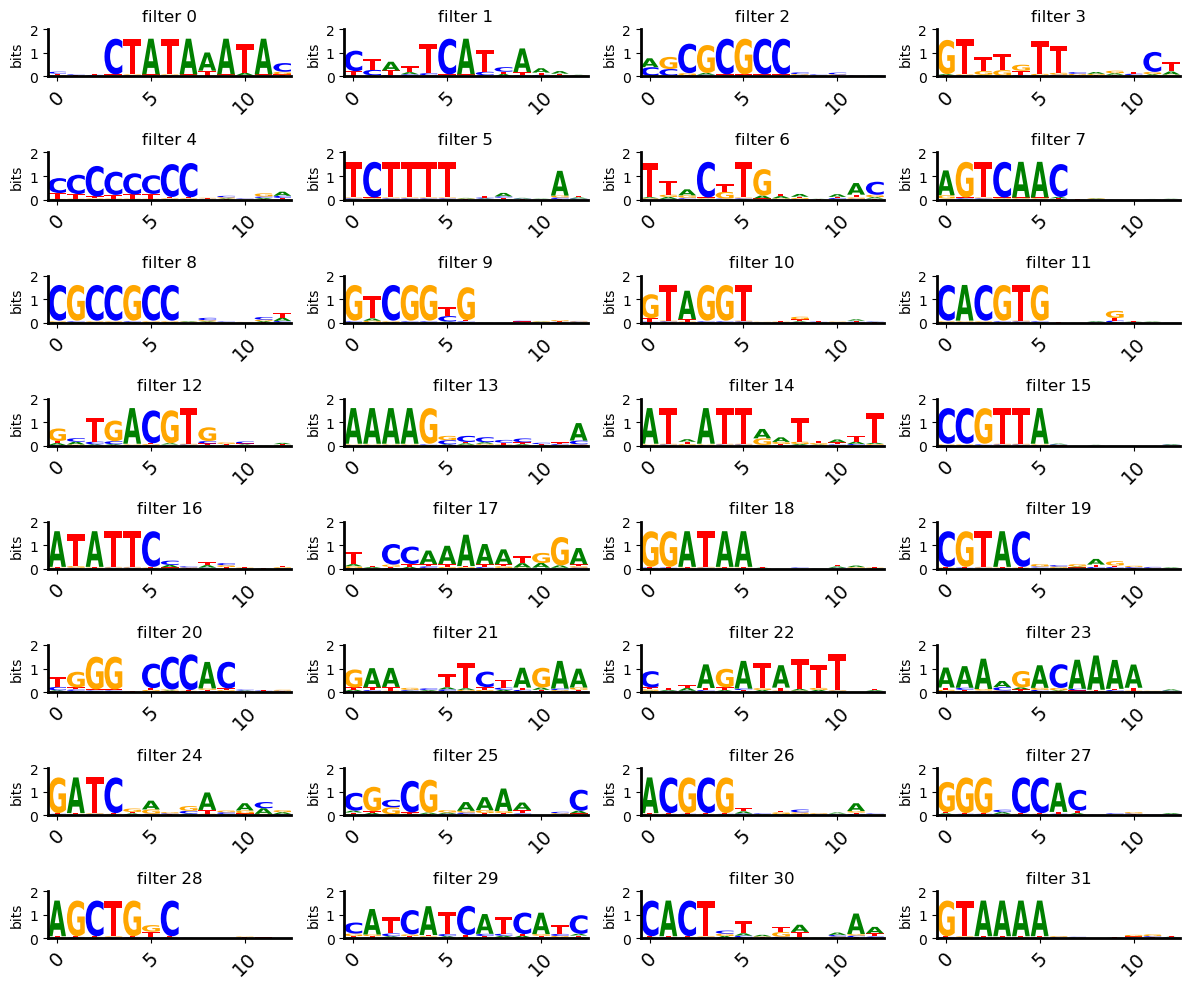

In [248]:
# Visualize multiple filters at once and save
for i in range(8):
    start_filter = i*32
    end_filter = (i*32) + 32
    print(f"Plotting and saving filters {start_filter+1}-{end_filter}")
    pl.multifilter_viz(
        sdata,
        filter_nums=range(start_filter, end_filter),
        pfms_key=f"{prefix}{layer_name}_pfms{suffix}",
        num_rows=8,
        num_cols=4,
        titles=[f"filter {i}" for i in range(start_filter, end_filter)],
        #save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_filters{start_filter+1}-{end_filter}_viz.pdf")
    )
    break

In [ ]:
# Save all the filter pfms from above as meme format for submission to TomTom
eu.dl.motif.filters_to_meme_sdata(
    sdata,
    filter_ids=list(sdata.uns["pfms"].keys()),
    output_dir=os.path.join(eu.settings.output_dir),
    file_name=f"{name}_best_model_filters.meme"
)

In [ ]:
sdata.write_h5sd(os.path.join(eu.settings.output_dir, f"{name}_test_predictions_and_interpretations.h5sd"))

## In silico evolution 

In [ ]:
# Load in sequences that were evolved in the published paper
sdata_evolve = eu.dl.read_csv(os.path.join(eu.settings.dataset_dir, "promoters_for_evolution.tsv"), seq_col="sequence", name_col="name")
eu.pp.ohe_seqs_sdata(sdata_evolve)
sdata_evolve

In [ ]:
# Evolve them using the best model across 10 rounds
eu.interpret.evolve_seqs_sdata(
    model,
    sdata_evolve,
    rounds=10
)

In [ ]:
# Plot the distribution of scores at different rounds of evolution
eu.pl.violinplot(
    sdata_evolve,
    groupby=["original_score", "evolved_3_score", "evolved_5_score", "evolved_10_score"],
    xlabel="Evolution Round",
    ylabel="Score",
    color = "lightblue",
    save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_evolution_summary.pdf")
)

In [ ]:
sdata_evolve.write_h5sd(os.path.join(eu.settings.output_dir, f"{name}_evolved_sequences.h5sd")) 

# In silico feature implant

In [ ]:
sdata_evolve = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, name, f"{name}_evolved_sequences.h5sd"))

In [ ]:
# Prep feature from meme file
meme = eu.dl.motif.MinimalMEME(path=os.path.join(eu.settings.dataset_dir, "CPEs.meme"))
motif = meme.motifs["TATA"]
feat_name = motif.name
pfm = motif.pfm
zero_pfm = np.zeros(pfm.shape)
rand_pfm = eu.pp.ohe_seq(eu.utils.random_seq(pfm.shape[0])).transpose()
consensus = motif.consensus
shuffled_pfm = eu.pp.ohe_seq(eu.pp.dinuc_shuffle_seq(consensus)).transpose()
feat_name, pfm, consensus

In [ ]:
# Slide the TATA motif across the sequences
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=pfm, 
    seqsm_key=f"slide_{feat_name}",
    encoding="onehot", 
    onehot=True
)

# Slide a random seq across the sequences
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=rand_pfm,
    seqsm_key=f"slide_random",
    encoding="onehot", 
    onehot=True
)

# Slide a zero ohe seq across the sequences 
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=zero_pfm,
    seqsm_key=f"slide_zero",
    encoding="onehot", 
    onehot=True
)

# Slide a TATA shuffled ohe seq across the sequences 
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=shuffled_pfm,
    seqsm_key=f"slide_shuffled",
    encoding="onehot", 
    onehot=True
)

In [ ]:
# Check the average percentage increase across the sequences and positions
mean_original = sdata_evolve["original_score"].mean()
avg_increase = np.mean(np.subtract(sdata_evolve.seqsm["slide_TATA"], np.expand_dims(sdata_evolve["original_score"], axis=1)), axis=1)
(avg_increase.mean()/mean_original).mean()*100

In [ ]:
# Generate a line plot
eu.pl.feature_implant_plot(
    sdata_evolve,
    seqsm_keys=[f"slide_{feat_name}", "slide_shuffled", "slide_zero", "slide_random"],
    save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_feature_implant_TATA.pdf")
)

In [ ]:
sdata_evolve.write_h5sd(os.path.join(eu.settings.output_dir, f"{name}_evolved_sequences_with_TATA_implant.h5sd")) 

---